# Landscape Objective Sensitivity Analysis

This notebook demonstrates how random conversion decisions affect the landscape objective value. We sample a 100x100 pixel area and show the immediate effect of land use conversion on landscape anomaly calculations.

## Overview

- **Load and sample initial conditions** from restoration optimization data
- **Visualize initial conditions** including landscape anomaly, LULC, and eligible pixels
- **Generate random conversion patterns** at different intensities
- **Calculate landscape objective** using the same formula as resto_anom.py
- **Analyze marginal gain surfaces** for restoration decisions
- **Test optimization signal strength** across objectives

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Import restoration optimization modules
from data_loader import load_initial_conditions
from resto_anom import recalculate_landscape_anomaly_with_conversions, restoration_effect
import tempfile
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("✓ Imports completed")

✓ Imports completed


## Load and Sample Landscape objective

In [2]:
# Load full initial conditions
initial_conditions = load_initial_conditions('.', objectives=['landscape'])
print('Loaded initial conditions with shape:', initial_conditions['shape'])
print('Available objectives:', [k for k in initial_conditions.keys() if 'anomaly' in k])

# Sample a 100x100 area from the center
full_shape = initial_conditions['shape']
center_r = full_shape[0] // 2
center_c = full_shape[1] // 2

# Define 100x100 sample area
sample_size = 100
start_r = max(0, center_r - sample_size // 2)
end_r = min(full_shape[0], start_r + sample_size)
start_c = max(0, center_c - sample_size // 2) 
end_c = min(full_shape[1], start_c + sample_size)

print(f'Sampling area: rows {start_r}:{end_r}, cols {start_c}:{end_c}')

# Sample the data
sample_shape = (end_r - start_r, end_c - start_c)
sampled_conditions = {}

# Sample spatial data
for key in ['landscape_anomaly', 'landscape_lulc_data', 'conversion_eligible_mask']:
    if key in initial_conditions:
        sampled_conditions[key] = initial_conditions[key][start_r:end_r, start_c:end_c]

# Sample other required data
sampled_conditions['shape'] = sample_shape
sampled_conditions['landscape_focal_classes'] = initial_conditions['landscape_focal_classes']
sampled_conditions['landscape_lulc_meta'] = initial_conditions['landscape_lulc_meta'].copy()

# Update metadata for sampled area
sampled_conditions['landscape_lulc_meta']['width'] = sample_shape[1]
sampled_conditions['landscape_lulc_meta']['height'] = sample_shape[0]

print(f'Sample shape: {sample_shape}')
print(f'Eligible pixels for conversion: {np.sum(sampled_conditions["conversion_eligible_mask"])}')

Loading initial conditions for objectives: ['landscape']
✓ Using Bern canton reference as validation reference
✓ Loaded landscape_anomaly: (2300, 3600)

--- Loading LULC data for ecosystem: all ---
✓ Loaded ecosystem LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/LULC_2018_agg.tif
✓ Loaded landscape LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/AS72_2018.tif
Loading pre-computed landscape density from: .\sn_dens.tif
✓ Loaded landscape density and converted to anomaly: (2300, 3600)
  (0/8280000 = 0.0% NaN)
  Ecosystem masking for restoration excluded 5562126 pixels
  Final restoration eligible pixels for all: 2717874
  Focal class masking for conversion excluded 2626035 pixels
  Final conversion eligible pixels (non-focal): 5653965
✓ Eligibility masks created:
  Restoration: 2717874/8280000 eligible pixels (32.8% of raster)
  Conversion: 5653965/8280000 eligible pixels (68.3% of raster)
✓ Filtered to Bern canton
✓ Cropped admin regions to

## Visualise example starting conditions

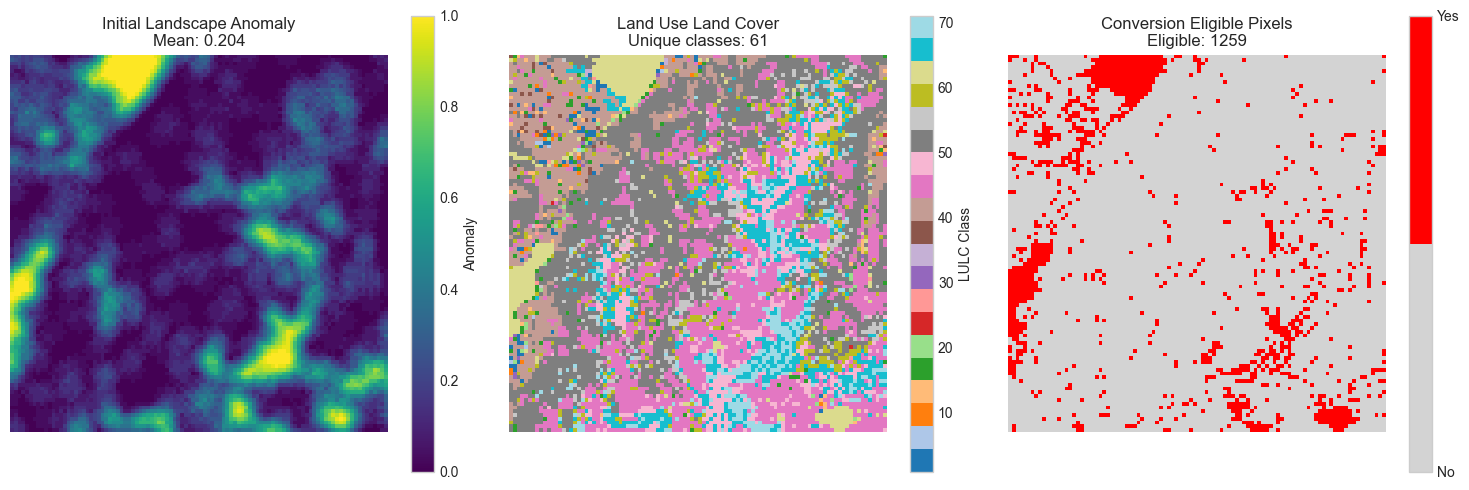

Sample area dimensions: (100, 100)
Focal classes for conversion: [12, 13, 16, 17]


In [3]:
# Extract data for visualization
landscape_anomaly = sampled_conditions['landscape_anomaly']
lulc_data = sampled_conditions['landscape_lulc_data']
conversion_eligible = sampled_conditions['conversion_eligible_mask'].astype(int)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Initial landscape anomaly
im1 = axes[0].imshow(landscape_anomaly, cmap='viridis', aspect='equal')
axes[0].set_title(f'Initial Landscape Anomaly\nMean: {np.mean(landscape_anomaly):.3f}')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], label='Anomaly')

# Plot 2: LULC classes
im2 = axes[1].imshow(lulc_data, cmap='tab20', aspect='equal')
axes[1].set_title(f'Land Use Land Cover\nUnique classes: {len(np.unique(lulc_data))}')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], label='LULC Class')

# Plot 3: Conversion eligible areas
colors = ['lightgray', 'red']
cmap = ListedColormap(colors)
im3 = axes[2].imshow(conversion_eligible, cmap=cmap, aspect='equal', vmin=0, vmax=1)
axes[2].set_title(f'Conversion Eligible Pixels\nEligible: {np.sum(conversion_eligible)}')
axes[2].axis('off')
cbar3 = plt.colorbar(im3, ax=axes[2], ticks=[0, 1])
cbar3.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

print(f"Sample area dimensions: {sample_shape}")
print(f"Focal classes for conversion: {sampled_conditions['landscape_focal_classes']}")

## Test impact of LULC conversion on objectives:
## 1. Generate Random Conversion Patterns

In [ ]:
# Test different conversion intensities
conversion_fractions = [0.05, 0.10, 0.15, 0.20]
results_list = []

for i, frac in enumerate(conversion_fractions):
    print(f"\n=== Testing conversion fraction: {frac*100:.1f}% ===")
    
    # Generate random conversion decisions
    eligible_pixels = np.sum(sampled_conditions['conversion_eligible_mask'])
    n_convert = int(frac * eligible_pixels)
    
    print(f'Converting {n_convert} pixels ({frac*100:.1f}% of {eligible_pixels} eligible)')
    
    # Create random conversion mask
    conversion_mask_2d = np.zeros(sampled_conditions['shape'], dtype=bool)
    if n_convert > 0:
        # Get eligible pixel coordinates
        eligible_coords = np.where(sampled_conditions['conversion_eligible_mask'])
        eligible_indices = list(zip(eligible_coords[0], eligible_coords[1]))
        
        # Randomly select pixels to convert
        np.random.seed(42 + i)  # Different seed for each fraction
        selected_indices = np.random.choice(len(eligible_indices), size=n_convert, replace=False)
        
        for idx in selected_indices:
            r, c = eligible_indices[idx]
            conversion_mask_2d[r, c] = True
    
    print(f'Conversion mask sum: {np.sum(conversion_mask_2d)}')
    
    # Calculate updated landscape anomaly
    try:
        updated_anomaly = recalculate_landscape_anomaly_with_conversions(
            sampled_conditions, conversion_mask_2d
        )
        
        # Calculate landscape objective value using the same formula as resto_anom.py
        eps = 1e-12
        landscape_objective = np.sum(updated_anomaly - sampled_conditions['landscape_anomaly']) / (np.sum(sampled_conditions['landscape_anomaly']) + eps)
        
        print(f'Initial landscape anomaly sum: {np.sum(sampled_conditions["landscape_anomaly"]):.6f}')
        print(f'Updated landscape anomaly sum: {np.sum(updated_anomaly):.6f}')
        print(f'Landscape objective value: {landscape_objective:.6f}')
        
        conversion_result = {
            'fraction': frac,
            'n_converted': n_convert,
            'landscape_objective': landscape_objective,
            'conversion_mask': conversion_mask_2d,
            'updated_anomaly': updated_anomaly
        }
        results_list.append(conversion_result)
        
    except Exception as e:
        print(f'Error in calculation: {e}')

# Create results summary
results_df = pd.DataFrame([
    {
        'Conversion_Fraction': r['fraction'],
        'Pixels_Converted': r['n_converted'],
        'Landscape_Objective': r['landscape_objective']
    }
    for r in results_list
])

print("\n=== Landscape Objective Response to Conversion Intensity ===")
print(results_df.round(6))

# Calculate sensitivity per pixel
sensitivity_per_pixel = results_df['Landscape_Objective'] / results_df['Pixels_Converted']
print(f"- Average objective change per pixel: {np.mean(sensitivity_per_pixel):.6f}")


=== Testing conversion fraction: 5.0% ===
Converting 62 pixels (5.0% of 1259 eligible)
Conversion mask sum: 62
Initial landscape anomaly sum: 2044.586207
Updated landscape anomaly sum: 9794.198242
Landscape objective value: 3.790308

=== Testing conversion fraction: 10.0% ===
Converting 125 pixels (10.0% of 1259 eligible)
Conversion mask sum: 125
Initial landscape anomaly sum: 2044.586207
Updated landscape anomaly sum: 9740.219727
Landscape objective value: 3.763908

=== Testing conversion fraction: 15.0% ===
Converting 188 pixels (15.0% of 1259 eligible)
Conversion mask sum: 188
Initial landscape anomaly sum: 2044.586207
Updated landscape anomaly sum: 9682.210938
Landscape objective value: 3.735536

=== Testing conversion fraction: 20.0% ===
Converting 251 pixels (20.0% of 1259 eligible)
Conversion mask sum: 251
Initial landscape anomaly sum: 2044.586207
Updated landscape anomaly sum: 9623.854492
Landscape objective value: 3.706994

=== Landscape Objective Response to Conversion Inte

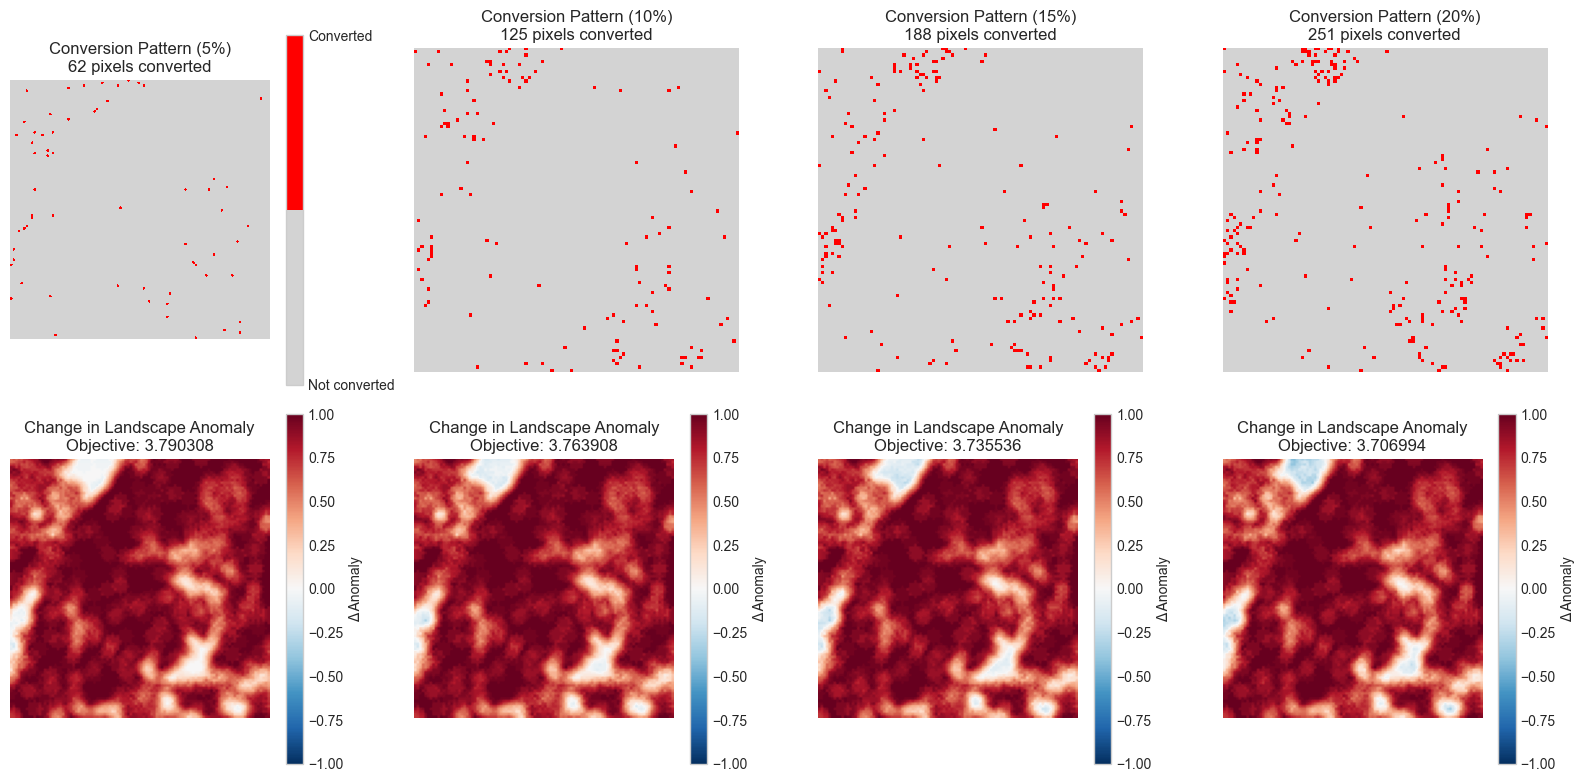

In [ ]:
# Plot conversion patterns and resulting changes
n_scenarios = len(results_list)
fig, axes = plt.subplots(2, n_scenarios, figsize=(4*n_scenarios, 8))

for i, result in enumerate(results_list):
    # Convert boolean mask to numeric for plotting
    conversion_mask_numeric = result['conversion_mask'].astype(int)
    
    # Create difference map
    difference = result['updated_anomaly'] - landscape_anomaly
    
    # Conversion pattern plot
    colors = ['lightgray', 'red']
    cmap = ListedColormap(colors)
    im1 = axes[0, i].imshow(conversion_mask_numeric, cmap=cmap, aspect='equal', vmin=0, vmax=1)
    axes[0, i].set_title(f'Conversion Pattern ({result["fraction"]*100:.0f}%)\n{result["n_converted"]} pixels converted')
    axes[0, i].axis('off')
    
    # Difference plot
    im2 = axes[1, i].imshow(difference, cmap='RdBu_r', aspect='equal', 
                           vmin=-np.max(np.abs(difference)), vmax=np.max(np.abs(difference)))
    axes[1, i].set_title(f'{result["landscape_objective"]:.6f}')
    axes[1, i].axis('off')
    
    # Add colorbars
    if i == 0:
        cbar1 = plt.colorbar(im1, ax=axes[0, i], ticks=[0, 1])
        cbar1.set_ticklabels(['Not converted', 'Converted'])
    
    plt.colorbar(im2, ax=axes[1, i], label='Δ Anomaly')

plt.tight_layout()
plt.show()

## Marginal Gain Analysis for Restoration

Based on the abiotic and biotic objective calculations in resto_anom.py, we can calculate the per-pixel marginal gain for restoration actions.

In [7]:
print('=== MARGINAL GAIN CALCULATION ===')

# Load full initial conditions with abiotic and biotic data
try:
    initial_conditions_full = load_initial_conditions('.', objectives=['abiotic', 'biotic'])
    
    # Sample the same area as landscape data
    abiotic_anomaly_sample = initial_conditions_full['abiotic_anomaly'][start_r:end_r, start_c:end_c]
    biotic_anomaly_sample = initial_conditions_full['biotic_anomaly'][start_r:end_r, start_c:end_c]
    restoration_eligible_sample = initial_conditions_full['restoration_eligible_mask'][start_r:end_r, start_c:end_c]
    
    print(f'Sampled abiotic anomaly shape: {abiotic_anomaly_sample.shape}')
    print(f'Sampled biotic anomaly shape: {biotic_anomaly_sample.shape}')
    print(f'Restoration eligible pixels in sample: {np.sum(restoration_eligible_sample)}')
    
    # Implement the anomaly improvement weight function (from resto_anom.py)
    def anomaly_improvement_weight(anomaly_values, shape='exponential', scale=1.0):
        neg_mask = anomaly_values < 0
        abs_anomaly = np.abs(anomaly_values)
        
        if shape == 'exponential':
            weights = 1 - np.exp(-abs_anomaly / scale)
        elif shape == 'gaussian':
            weights = np.exp(-(abs_anomaly**2) / (2 * scale**2))
        else:
            raise ValueError(f'Unknown weight shape: {shape}')
        
        gamma = 3.0
        weights = weights ** gamma
        weights = np.where(neg_mask, weights, 0.0)
        weights = np.clip(weights, 0.0, 1.0)
        
        return weights
    
    # Default restoration effect parameters (from resto_anom.py defaults)
    abiotic_effect = 0.01  # Default abiotic improvement
    biotic_effect = 0.01   # Default biotic improvement
    weight_shape = 'exponential'
    weight_scale = 1.0
    
    # Calculate improvement weights for each pixel
    abiotic_weights = anomaly_improvement_weight(abiotic_anomaly_sample, shape=weight_shape, scale=weight_scale)
    biotic_weights = anomaly_improvement_weight(biotic_anomaly_sample, shape=weight_shape, scale=weight_scale)
    
    # Calculate marginal gain per pixel (improvement * weight)
    abiotic_marginal_gain = abiotic_effect * abiotic_weights
    biotic_marginal_gain = biotic_effect * biotic_weights
    
    # Apply restoration eligibility mask
    abiotic_marginal_gain = np.where(restoration_eligible_sample, abiotic_marginal_gain, 0.0)
    biotic_marginal_gain = np.where(restoration_eligible_sample, biotic_marginal_gain, 0.0)
    
    print(f'Abiotic marginal gain range: {np.min(abiotic_marginal_gain):.6f} to {np.max(abiotic_marginal_gain):.6f}')
    print(f'Biotic marginal gain range: {np.min(biotic_marginal_gain):.6f} to {np.max(biotic_marginal_gain):.6f}')
    print(f'Non-zero abiotic gains: {np.sum(abiotic_marginal_gain > 0)} pixels')
    print(f'Non-zero biotic gains: {np.sum(biotic_marginal_gain > 0)} pixels')
    
    marginal_gain_available = True
    
except Exception as e:
    print(f"Could not load abiotic/biotic data for marginal gain analysis: {e}")
    marginal_gain_available = False

=== MARGINAL GAIN CALCULATION ===
Loading initial conditions for objectives: ['abiotic', 'biotic']
✓ Using Bern canton reference as validation reference
✓ Loaded abiotic_anomaly: (1131, 1215) (937055/1374165 = 68.2% NaN)
✓ Loaded biotic_anomaly: (1131, 1215) (937003/1374165 = 68.2% NaN)

--- Loading LULC data for ecosystem: all ---
✓ Loaded ecosystem LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/LULC_2018_agg.tif
✓ Loaded landscape LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/AS72_2018.tif
  Masking 937055 NaN pixels from abiotic_anomaly
  Masking 937003 NaN pixels from biotic_anomaly
  Ecosystem masking for restoration excluded 0 pixels
  Final restoration eligible pixels for all: 437110
  Focal class masking for conversion excluded 362608 pixels
  Final conversion eligible pixels (non-focal): 74502
✓ Eligibility masks created:
  Restoration: 437110/1374165 eligible pixels (31.8% of raster)
  Conversion: 74502/1374165 eligible pixels 

In [8]:
if marginal_gain_available:
    # Visualize marginal gain surfaces
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Top row: Baseline anomalies
    im1 = axes[0, 0].imshow(abiotic_anomaly_sample, cmap='plasma', aspect='equal')
    axes[0, 0].set_title(f'Abiotic Anomaly (Baseline)\nRange: {np.min(abiotic_anomaly_sample):.3f} to {np.max(abiotic_anomaly_sample):.3f}')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], label='Anomaly')
    
    im2 = axes[0, 1].imshow(biotic_anomaly_sample, cmap='plasma', aspect='equal')
    axes[0, 1].set_title(f'Biotic Anomaly (Baseline)\nRange: {np.min(biotic_anomaly_sample):.3f} to {np.max(biotic_anomaly_sample):.3f}')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], label='Anomaly')
    
    # Restoration eligible
    colors = ['lightgray', 'darkgreen']
    cmap = ListedColormap(colors)
    im3 = axes[0, 2].imshow(restoration_eligible_sample.astype(int), cmap=cmap, aspect='equal', vmin=0, vmax=1)
    axes[0, 2].set_title(f'Restoration Eligible Pixels\nEligible: {np.sum(restoration_eligible_sample)} of {restoration_eligible_sample.size}')
    axes[0, 2].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[0, 2], ticks=[0, 1])
    cbar3.set_ticklabels(['No', 'Yes'])
    
    # Bottom row: Marginal gain surfaces
    # Use sqrt normalization to show detail in low values
    from matplotlib.colors import PowerNorm
    
    im4 = axes[1, 0].imshow(abiotic_marginal_gain, cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
    axes[1, 0].set_title(f'Abiotic Marginal Gain per Pixel\nMax gain: {np.max(abiotic_marginal_gain):.4f} | Non-zero: {np.sum(abiotic_marginal_gain > 0)}')
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], label='Marginal Gain')
    
    im5 = axes[1, 1].imshow(biotic_marginal_gain, cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
    axes[1, 1].set_title(f'Biotic Marginal Gain per Pixel\nMax gain: {np.max(biotic_marginal_gain):.4f} | Non-zero: {np.sum(biotic_marginal_gain > 0)}')
    axes[1, 1].axis('off')
    plt.colorbar(im5, ax=axes[1, 1], label='Marginal Gain')
    
    # Combined marginal gain
    combined_gain = abiotic_marginal_gain + biotic_marginal_gain
    im6 = axes[1, 2].imshow(combined_gain, cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
    axes[1, 2].set_title(f'Combined Marginal Gain\nMax: {np.max(combined_gain):.4f}')
    axes[1, 2].axis('off')
    plt.colorbar(im6, ax=axes[1, 2], label='Combined Gain')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics for eligible pixels
    eligible_mask = restoration_eligible_sample.astype(bool)
    if np.sum(eligible_mask) > 0:
        abiotic_gains_eligible = abiotic_marginal_gain[eligible_mask]
        biotic_gains_eligible = biotic_marginal_gain[eligible_mask]
        
        gain_stats = pd.DataFrame({
            'Objective': ['Abiotic', 'Biotic'],
            'Effect_Parameter': [abiotic_effect, biotic_effect],
            'Mean_Gain': [np.mean(abiotic_gains_eligible), np.mean(biotic_gains_eligible)],
            'Median_Gain': [np.median(abiotic_gains_eligible), np.median(biotic_gains_eligible)],
            'Max_Gain': [np.max(abiotic_gains_eligible), np.max(biotic_gains_eligible)],
            'Min_Gain': [np.min(abiotic_gains_eligible), np.min(biotic_gains_eligible)],
            'SD_Gain': [np.std(abiotic_gains_eligible), np.std(biotic_gains_eligible)],
            'Eligible_Pixels': [np.sum(abiotic_gains_eligible > 0), np.sum(biotic_gains_eligible > 0)]
        })
        
        print("\n=== Marginal Gain Statistics for Restoration-Eligible Pixels ===")
        print(gain_stats.round(6))
        
        # Distribution plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.hist(abiotic_gains_eligible, bins=30, alpha=0.7, color='purple', label='Abiotic')
        ax1.set_xlabel('Marginal Gain per Pixel')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Abiotic Marginal Gains')
        ax1.grid(True, alpha=0.3)
        
        ax2.hist(biotic_gains_eligible, bins=30, alpha=0.7, color='orange', label='Biotic')
        ax2.set_xlabel('Marginal Gain per Pixel')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Biotic Marginal Gains')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
else:
    print("Marginal gain analysis skipped - abiotic/biotic data not available")

Marginal gain analysis skipped - abiotic/biotic data not available


## Optimization Signal Analysis

This analysis tests whether restoration and conversion decisions produce meaningful objective variation - essential for effective optimization.

In [9]:
print('=== OPTIMIZATION SIGNAL CHECK ===')

# Create a simple problem setup for signal testing
scenario_params_test = {
    'max_restoration_fraction': 0.2,
    'spatial_clustering': 0.0,
    'burden_sharing': 'no',
    'abiotic_effect': 0.01,
    'biotic_effect': 0.01,
    'anomaly_weight_shape': 'exponential',
    'anomaly_weight_scale': 1.0
}

# Load initial conditions for all objectives
try:
    initial_conditions_test = load_initial_conditions('.', objectives=['abiotic', 'biotic', 'landscape', 'cost'])
    
    print(f'Loaded objectives: {[k for k in initial_conditions_test.keys() if "anomaly" in k or k == "implementation_cost"]}')
    print(f'Restoration eligible pixels: {initial_conditions_test["n_restoration_pixels"]}')
    print(f'Conversion eligible pixels: {initial_conditions_test["n_conversion_pixels"]}')
    
    # Quick signal check: test different action fractions
    test_fractions = [0.05, 0.15, 0.25, 0.35]
    n_samples = 5
    conv_share = 0.5  # Share actions between restoration (0.5) and conversion (0.5)
    
    # Determine available objectives
    objective_names = []
    for obj in ['abiotic_anomaly', 'biotic_anomaly', 'landscape_anomaly', 'implementation_cost']:
        if obj in initial_conditions_test:
            objective_names.append(obj)
    
    print(f'Testing objectives: {objective_names}')
    
    # Calculate action budgets
    n_restoration_pixels = initial_conditions_test['n_restoration_pixels']
    n_conversion_pixels = initial_conditions_test['n_conversion_pixels']
    max_restored_pixels = int(scenario_params_test['max_restoration_fraction'] * n_restoration_pixels)
    
    signal_results = {}
    
    for obj_name in objective_names:
        print(f'\nTesting {obj_name}...')
        objective_values = []
        
        for frac in test_fractions:
            n_actions = int(frac * max_restored_pixels)
            
            for sample in range(n_samples):
                np.random.seed(42 + sample + int(frac*100))
                
                # Split actions between restoration and conversion
                n_conv = int(round(conv_share * n_actions))
                n_rest = n_actions - n_conv
                
                # Ensure we don't exceed available pixels
                n_rest = min(n_rest, n_restoration_pixels)
                n_conv = min(n_conv, n_conversion_pixels)
                
                # Create decision vectors
                restore_vars = np.zeros(n_restoration_pixels, dtype=int)
                convert_vars = np.zeros(n_conversion_pixels, dtype=int)
                
                if n_rest > 0:
                    rest_idx = np.random.permutation(n_restoration_pixels)[:n_rest]
                    restore_vars[rest_idx] = 1
                
                if n_conv > 0:
                    conv_idx = np.random.permutation(n_conversion_pixels)[:n_conv]
                    convert_vars[conv_idx] = 1
                
                # Calculate objective value
                updated_conditions = restoration_effect(restore_vars, convert_vars, initial_conditions_test, scenario_params_test)
                
                if obj_name in ['abiotic_anomaly', 'biotic_anomaly']:
                    # Maximize improvement relative to baseline
                    base = initial_conditions_test[obj_name]
                    mask = initial_conditions_test['restoration_eligible_mask']
                    obj_value = -np.sum((updated_conditions[obj_name] - base)[mask])
                    
                elif obj_name == 'landscape_anomaly':
                    # Relative change in landscape anomaly
                    l0 = initial_conditions_test['landscape_anomaly']
                    l1 = updated_conditions['landscape_anomaly']
                    eps = 1e-12
                    obj_value = np.sum(l1 - l0) / (np.sum(l0) + eps)
                    
                elif obj_name == 'implementation_cost':
                    obj_value = updated_conditions[obj_name]
                else:
                    obj_value = 0.0
                
                objective_values.append(obj_value)
                
                if sample == 0 and frac == test_fractions[0]:  # Debug first sample
                    print(f'  Sample: {n_rest} restore + {n_conv} convert = {n_rest + n_conv} total actions')
                    print(f'  Objective value: {obj_value:.6f}')
        
        # Calculate signal statistics
        if len(objective_values) > 1:
            obj_range = float(np.max(objective_values) - np.min(objective_values))
            mean_val = float(np.mean(objective_values))
            std_val = float(np.std(objective_values))
            cv = std_val / abs(mean_val) if mean_val != 0 else 0.0
            
            signal_results[obj_name] = {
                'range': obj_range,
                'mean': mean_val,
                'std': std_val,
                'cv': cv,
                'values': objective_values
            }
            
            print(f'  Range: {obj_range:.2e}')
            print(f'  Mean: {mean_val:.6f}')
            print(f'  CV (std/mean): {cv:.3f}')
        else:
            print(f'  No values collected for {obj_name}')
    
    # Overall signal assessment
    cv_threshold = 0.1
    has_signal = any(result['cv'] > cv_threshold for result in signal_results.values())
    
    print(f'\n=== SIGNAL ASSESSMENT ===')
    print(f'CV threshold for meaningful signal: {cv_threshold}')
    print(f'Optimization signal: {"✓ PRESENT" if has_signal else "✗ WEAK or ABSENT"}')
    
    signal_test_available = True
    
except Exception as e:
    print(f'Error in signal analysis: {e}')
    signal_test_available = False

=== OPTIMIZATION SIGNAL CHECK ===
Loading initial conditions for objectives: ['abiotic', 'biotic', 'landscape', 'cost']
✓ Using Bern canton reference as validation reference
✓ Loaded abiotic_anomaly: (1131, 1215) (937055/1374165 = 68.2% NaN)
✓ Loaded biotic_anomaly: (1131, 1215) (937003/1374165 = 68.2% NaN)
  Note: landscape_anomaly has different specs - will resample to match reference
✓ Loaded landscape_anomaly: (2300, 3600)
✓ Loaded implementation_cost: (1131, 1215) (11705/1374165 = 0.9% NaN)

--- Loading LULC data for ecosystem: all ---
✓ Loaded ecosystem LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/LULC_2018_agg.tif
✓ Loaded landscape LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/AS72_2018.tif
Loading pre-computed landscape density from: .\sn_dens.tif
  Landscape shape mismatch: (2300, 3600) vs (1131, 1215) - will resample
  Landscape transform mismatch - will resample
🔄 Resampling landscape to match reference data...
✓ Resampled 


=== Optimization Signal Analysis - Objective Variation Test ===
             Objective        Range         Mean     Std_Dev        CV  Signal
0      abiotic_anomaly    12.537445    -9.542458    4.610622  0.483169  Strong
1       biotic_anomaly    27.511753   -20.639097   10.101015  0.489412  Strong
2    landscape_anomaly     0.022484     1.285146    0.008379  0.006520    Weak
3  implementation_cost  2221.954590  1438.724609  804.254883  0.559005  Strong


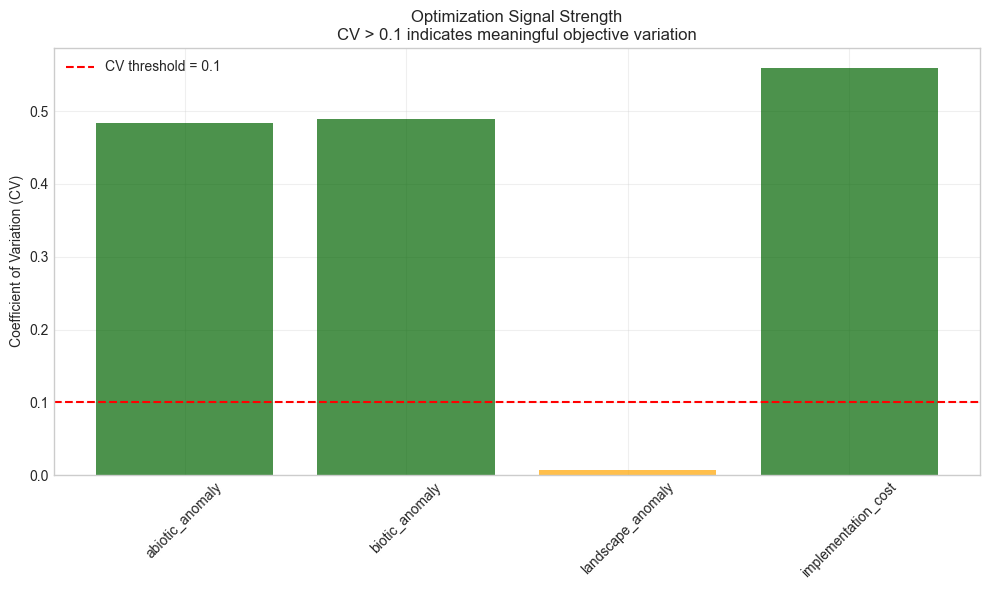


✓ **OPTIMIZATION SIGNAL PRESENT**
Objectives show meaningful variation with different restoration/conversion decisions.
Optimization should be able to find diverse trade-off solutions.

**Test Parameters:**
- Action fractions tested: [0.05, 0.15, 0.25, 0.35]
- Samples per fraction: 5
- Conversion share: 0.5
- Max restored pixels: 87421


In [10]:
if signal_test_available and signal_results:
    # Create signal summary
    signal_summary = pd.DataFrame([
        {
            'Objective': obj_name,
            'Range': result['range'],
            'Mean': result['mean'],
            'Std_Dev': result['std'],
            'CV': result['cv'],
            'Signal': 'Strong' if result['cv'] > cv_threshold else 'Weak'
        }
        for obj_name, result in signal_results.items()
    ])
    
    print("\n=== Optimization Signal Analysis - Objective Variation Test ===")
    print(signal_summary.round(6))
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    colors = ['darkgreen' if signal == 'Strong' else 'orange' for signal in signal_summary['Signal']]
    bars = ax.bar(signal_summary['Objective'], signal_summary['CV'], color=colors, alpha=0.7)
    ax.axhline(y=cv_threshold, color='red', linestyle='--', label=f'CV threshold = {cv_threshold}')
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_title('Optimization Signal Strength\nCV > 0.1 indicates meaningful objective variation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Assessment
    if has_signal:
        print("\n✓ **OPTIMIZATION SIGNAL PRESENT**")
        print("Objectives show meaningful variation with different restoration/conversion decisions.")
        print("Optimization should be able to find diverse trade-off solutions.")
    else:
        print("\n⚠ **WEAK OPTIMIZATION SIGNAL**")
        print("Limited objective variation detected. Consider:")
        print("- Adjusting restoration effect parameters")
        print("- Increasing action budgets")
        print("- Reviewing objective formulations")
    
    print(f"\n**Test Parameters:**")
    print(f"- Action fractions tested: {test_fractions}")
    print(f"- Samples per fraction: {n_samples}")
    print(f"- Conversion share: {conv_share}")
    print(f"- Max restored pixels: {max_restored_pixels}")
    
else:
    print("Signal analysis failed or no results available.")

## Comprehensive Optimization Diagnostics

This section includes the full diagnostic suite from resto_anom.py to validate optimization setup, detect common issues, and assess problem characteristics.

In [11]:
# Import additional diagnostic functions from resto_anom
from resto_anom import diagnose_optimization_setup, RestorationProblem
from scenarios import define_scenario_parameters

print("✓ Diagnostic imports completed")

✓ Diagnostic imports completed


In [12]:
def check_optimization_signal_with_conversion(initial_conditions, scenario_params, verbose=False):
    """
    Test if optimization objectives show meaningful variation with different decisions.
    Essential diagnostic to ensure optimization can find diverse trade-off solutions.
    
    Returns:
        bool: True if sufficient signal detected, False otherwise
    """
    if verbose:
        print("=== OPTIMIZATION SIGNAL CHECK WITH CONVERSION ===")
    
    # Test parameters
    test_fractions = [0.05, 0.15, 0.25, 0.35]
    n_samples = 5
    conv_share = 0.5  # Share actions between restoration and conversion
    cv_threshold = 0.1  # CV threshold for meaningful signal
    
    # Determine available objectives
    objective_names = []
    for obj in ['abiotic_anomaly', 'biotic_anomaly', 'landscape_anomaly', 'implementation_cost']:
        if obj in initial_conditions:
            objective_names.append(obj)
    
    if verbose:
        print(f"Testing objectives: {objective_names}")
    
    # Calculate action budgets
    n_restoration_pixels = initial_conditions.get('n_restoration_pixels', 0)
    n_conversion_pixels = initial_conditions.get('n_conversion_pixels', 0)
    max_restoration_fraction = scenario_params.get('max_restoration_fraction', 0.2)
    max_restored_pixels = int(max_restoration_fraction * n_restoration_pixels)
    
    if verbose:
        print(f"Max restored pixels: {max_restored_pixels}")
        print(f"Available conversion pixels: {n_conversion_pixels}")
    
    signal_results = {}
    
    for obj_name in objective_names:
        if verbose:
            print(f"\\nTesting {obj_name}...")
            
        objective_values = []
        
        for frac in test_fractions:
            n_actions = int(frac * max_restored_pixels)
            
            for sample in range(n_samples):
                np.random.seed(42 + sample + int(frac*100))
                
                # Split actions between restoration and conversion
                n_conv = int(round(conv_share * n_actions))
                n_rest = n_actions - n_conv
                
                # Ensure we don't exceed available pixels
                n_rest = min(n_rest, n_restoration_pixels)
                n_conv = min(n_conv, n_conversion_pixels)
                
                # Create decision vectors
                restore_vars = np.zeros(n_restoration_pixels, dtype=int)
                convert_vars = np.zeros(n_conversion_pixels, dtype=int)
                
                if n_rest > 0:
                    rest_idx = np.random.permutation(n_restoration_pixels)[:n_rest]
                    restore_vars[rest_idx] = 1
                
                if n_conv > 0:
                    conv_idx = np.random.permutation(n_conversion_pixels)[:n_conv]
                    convert_vars[conv_idx] = 1
                
                # Calculate objective value
                try:
                    updated_conditions = restoration_effect(restore_vars, convert_vars, initial_conditions, scenario_params)
                    
                    if obj_name in ['abiotic_anomaly', 'biotic_anomaly']:
                        # Maximize improvement relative to baseline
                        base = initial_conditions[obj_name]
                        mask = initial_conditions['restoration_eligible_mask']
                        obj_value = -np.sum((updated_conditions[obj_name] - base)[mask])
                        
                    elif obj_name == 'landscape_anomaly':
                        # Relative change in landscape anomaly
                        l0 = initial_conditions['landscape_anomaly']
                        l1 = updated_conditions['landscape_anomaly']
                        eps = 1e-12
                        obj_value = np.sum(l1 - l0) / (np.sum(l0) + eps)
                        
                    elif obj_name == 'implementation_cost':
                        obj_value = updated_conditions[obj_name]
                    else:
                        obj_value = 0.0
                    
                    objective_values.append(obj_value)
                    
                except Exception as e:
                    if verbose:
                        print(f"  Error in sample calculation: {e}")
                    continue
        
        # Calculate signal statistics
        if len(objective_values) > 1:
            obj_range = float(np.max(objective_values) - np.min(objective_values))
            mean_val = float(np.mean(objective_values))
            std_val = float(np.std(objective_values))
            cv = std_val / abs(mean_val) if abs(mean_val) > 1e-12 else 0.0
            
            signal_results[obj_name] = {
                'range': obj_range,
                'mean': mean_val,
                'std': std_val,
                'cv': cv,
                'values': objective_values
            }
            
            if verbose:
                print(f"  Range: {obj_range:.2e}")
                print(f"  Mean: {mean_val:.6f}")
                print(f"  CV: {cv:.3f}")
        else:
            if verbose:
                print(f"  No valid values collected for {obj_name}")
    
    # Overall signal assessment
    has_signal = any(result['cv'] > cv_threshold for result in signal_results.values())
    
    if verbose:
        print(f"\\n=== SIGNAL ASSESSMENT ===")
        print(f"CV threshold for meaningful signal: {cv_threshold}")
        print(f"Optimization signal: {'✓ PRESENT' if has_signal else '✗ WEAK or ABSENT'}")
        
        if not has_signal:
            print("\\nRecommendations:")
            print("- Increase restoration effect parameters")
            print("- Increase max_restoration_fraction")
            print("- Check if objectives are properly configured")
    
    return has_signal

print("✓ Signal check function defined")

✓ Signal check function defined


In [13]:
def analyze_decision_patterns(decisions, initial_conditions):
    """
    Analyze decision patterns from optimization results.
    
    Args:
        decisions: Binary array of restoration/conversion decisions
        initial_conditions: Dict with initial data
        
    Returns:
        dict: Analysis results
    """
    n_restoration_pixels = initial_conditions.get('n_restoration_pixels', 0)
    n_conversion_pixels = initial_conditions.get('n_conversion_pixels', 0)
    
    # Split decisions into restoration and conversion
    if len(decisions) >= n_restoration_pixels:
        restore_decisions = decisions[:n_restoration_pixels]
        convert_decisions = decisions[n_restoration_pixels:n_restoration_pixels + n_conversion_pixels] if len(decisions) > n_restoration_pixels else np.zeros(n_conversion_pixels)
    else:
        restore_decisions = decisions
        convert_decisions = np.zeros(n_conversion_pixels)
    
    # Calculate statistics
    n_restored = np.sum(restore_decisions)
    n_converted = np.sum(convert_decisions)
    total_actions = n_restored + n_converted
    
    # Restoration rate relative to available pixels
    restore_rate = n_restored / n_restoration_pixels if n_restoration_pixels > 0 else 0
    convert_rate = n_converted / n_conversion_pixels if n_conversion_pixels > 0 else 0
    
    # Action balance
    action_balance = n_converted / total_actions if total_actions > 0 else 0
    
    analysis = {
        'n_restored': n_restored,
        'n_converted': n_converted,
        'total_actions': total_actions,
        'restore_rate': restore_rate,
        'convert_rate': convert_rate,
        'action_balance': action_balance,
        'restoration_fraction': n_restored / total_actions if total_actions > 0 else 0,
        'conversion_fraction': n_converted / total_actions if total_actions > 0 else 0
    }
    
    return analysis

def run_comprehensive_diagnostics(initial_conditions, scenario_params, n_samples=10):
    """
    Run comprehensive optimization diagnostics with visualization.
    
    This combines the main diagnostic functions from resto_anom.py with 
    notebook-friendly visualization and reporting.
    """
    print("\\n" + "="*70)
    print("COMPREHENSIVE OPTIMIZATION DIAGNOSTICS")
    print("="*70)
    
    # === 1. BASIC SETUP VALIDATION ===
    print("\\n1. BASIC SETUP VALIDATION")
    print("-" * 30)
    
    # Check data availability
    required_keys = ['shape', 'restoration_eligible_mask', 'conversion_eligible_mask']
    missing_keys = [key for key in required_keys if key not in initial_conditions]
    if missing_keys:
        print(f"❌ Missing required data: {missing_keys}")
        return False
    else:
        print("✓ All required data present")
    
    # Check pixel counts
    n_restoration_pixels = initial_conditions.get('n_restoration_pixels', 0)
    n_conversion_pixels = initial_conditions.get('n_conversion_pixels', 0)
    max_restoration_fraction = scenario_params.get('max_restoration_fraction', 0.2)
    max_action_pixels = int(max_restoration_fraction * n_restoration_pixels)
    
    print(f"✓ Restoration eligible pixels: {n_restoration_pixels:,}")
    print(f"✓ Conversion eligible pixels: {n_conversion_pixels:,}")
    print(f"✓ Max action pixels (at {max_restoration_fraction:.1%}): {max_action_pixels:,}")
    
    if max_action_pixels == 0:
        print("❌ No action pixels available - check max_restoration_fraction")
        return False
    
    # Check objectives
    anomaly_objectives = [obj for obj in ['abiotic_anomaly', 'biotic_anomaly', 'landscape_anomaly'] 
                         if obj in initial_conditions]
    print(f"✓ Available anomaly objectives: {anomaly_objectives}")
    
    if not anomaly_objectives:
        print("❌ No anomaly objectives available")
        return False
    
    # === 2. BASELINE OBJECTIVE VALUES ===
    print("\\n2. BASELINE OBJECTIVE VALUES")
    print("-" * 30)
    
    baseline_stats = {}
    for obj_name in anomaly_objectives:
        data = initial_conditions[obj_name]
        eligible_mask = initial_conditions.get('restoration_eligible_mask', 
                                             initial_conditions.get('eligible_mask'))
        
        if eligible_mask is not None:
            eligible_data = data[eligible_mask]
            stats = {
                'mean': float(np.mean(eligible_data)),
                'std': float(np.std(eligible_data)),
                'min': float(np.min(eligible_data)),
                'max': float(np.max(eligible_data)),
                'sum': float(np.sum(eligible_data)),
                'negative_fraction': float(np.mean(eligible_data < 0))
            }
            baseline_stats[obj_name] = stats
            
            print(f"  {obj_name}:")
            print(f"    Sum: {stats['sum']:.6f}")
            print(f"    Mean: {stats['mean']:.6f} ± {stats['std']:.6f}")
            print(f"    Range: [{stats['min']:.6f}, {stats['max']:.6f}]")
            print(f"    Negative pixels: {stats['negative_fraction']:.1%}")
    
    # === 3. SAMPLE SOLUTION TESTING ===
    print("\\n3. SAMPLE SOLUTION TESTING")
    print("-" * 30)
    
    try:
        # Create a simplified problem for testing
        test_objective_values = []
        feasible_count = 0
        
        for i in range(n_samples):
            np.random.seed(42 + i)
            
            # Generate random solution
            n_actions = np.random.randint(1, min(max_action_pixels + 1, 100))
            
            # Split between restoration and conversion
            n_restore = np.random.randint(0, min(n_actions + 1, n_restoration_pixels + 1))
            n_convert = min(n_actions - n_restore, n_conversion_pixels)
            
            # Create decision vectors
            restore_vars = np.zeros(n_restoration_pixels, dtype=int)
            convert_vars = np.zeros(n_conversion_pixels, dtype=int)
            
            if n_restore > 0:
                rest_idx = np.random.choice(n_restoration_pixels, size=n_restore, replace=False)
                restore_vars[rest_idx] = 1
            
            if n_convert > 0:
                conv_idx = np.random.choice(n_conversion_pixels, size=n_convert, replace=False)
                convert_vars[conv_idx] = 1
            
            # Test restoration effect calculation
            try:
                updated_conditions = restoration_effect(restore_vars, convert_vars, 
                                                      initial_conditions, scenario_params)
                
                # Calculate a simple objective (abiotic improvement)
                if 'abiotic_anomaly' in updated_conditions:
                    base = initial_conditions['abiotic_anomaly']
                    updated = updated_conditions['abiotic_anomaly']
                    eligible_mask = initial_conditions.get('restoration_eligible_mask')
                    
                    if eligible_mask is not None:
                        improvement = np.sum((base - updated)[eligible_mask])
                        test_objective_values.append(improvement)
                        feasible_count += 1
                        
                        if i < 3:  # Show details for first few
                            print(f"  Sample {i+1}: {n_restore} restore + {n_convert} convert → improvement = {improvement:.6f}")
                    
            except Exception as e:
                print(f"  Sample {i+1}: Error - {str(e)[:50]}...")
                continue
        
        print(f"\\n  Results: {feasible_count}/{n_samples} samples successful")
        
        if test_objective_values:
            obj_range = np.max(test_objective_values) - np.min(test_objective_values)
            print(f"  Objective range: {obj_range:.6f}")
            print(f"  Mean objective: {np.mean(test_objective_values):.6f}")
            
            if obj_range > 1e-12:
                print("  ✓ Objectives show variation across solutions")
            else:
                print("  ⚠ Limited objective variation detected")
        
    except Exception as e:
        print(f"  Error in sample testing: {e}")
    
    # === 4. OPTIMIZATION SIGNAL CHECK ===
    print("\\n4. OPTIMIZATION SIGNAL CHECK")
    print("-" * 30)
    
    try:
        has_signal = check_optimization_signal_with_conversion(initial_conditions, scenario_params, verbose=True)
        return has_signal
    except Exception as e:
        print(f"Error in signal check: {e}")
        return False
    
    return True

print("✓ Comprehensive diagnostics function defined")

✓ Comprehensive diagnostics function defined


### Run Full Diagnostic Suite

Now let's run the comprehensive diagnostics on our test scenario to validate the optimization setup.

In [14]:
# Load full initial conditions for comprehensive diagnostics
try:
    initial_conditions_diag = load_initial_conditions('.', objectives=['abiotic', 'biotic', 'landscape', 'cost'])
    
    # Define test scenario parameters
    test_scenario_params = {
        'max_restoration_fraction': 0.2,
        'spatial_clustering': 0.0,
        'burden_sharing': 'no',
        'abiotic_effect': 0.01,
        'biotic_effect': 0.01,
        'anomaly_weight_shape': 'exponential',
        'anomaly_weight_scale': 1.0
    }
    
    print("="*50)
    print("RUNNING COMPREHENSIVE DIAGNOSTICS")
    print("="*50)
    print(f"Loaded data shape: {initial_conditions_diag['shape']}")
    print(f"Test scenario: max_restoration_fraction = {test_scenario_params['max_restoration_fraction']}")
    print(f"Effect parameters: abiotic = {test_scenario_params['abiotic_effect']}, biotic = {test_scenario_params['biotic_effect']}")
    
    # Run the comprehensive diagnostics
    diagnostics_passed = run_comprehensive_diagnostics(initial_conditions_diag, test_scenario_params, n_samples=10)
    
    print("\\n" + "="*50)
    if diagnostics_passed:
        print("✅ DIAGNOSTICS PASSED - Optimization setup appears valid")
    else:
        print("❌ DIAGNOSTICS FAILED - Issues detected in optimization setup")
    print("="*50)
    
except Exception as e:
    print(f"Error running diagnostics: {e}")
    import traceback
    traceback.print_exc()

Loading initial conditions for objectives: ['abiotic', 'biotic', 'landscape', 'cost']
✓ Using Bern canton reference as validation reference
✓ Loaded abiotic_anomaly: (1131, 1215) (937055/1374165 = 68.2% NaN)
✓ Loaded biotic_anomaly: (1131, 1215) (937003/1374165 = 68.2% NaN)
  Note: landscape_anomaly has different specs - will resample to match reference
✓ Loaded landscape_anomaly: (2300, 3600)
✓ Loaded implementation_cost: (1131, 1215) (11705/1374165 = 0.9% NaN)

--- Loading LULC data for ecosystem: all ---
✓ Loaded ecosystem LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/LULC_2018_agg.tif
✓ Loaded landscape LULC raster: W:/EU_BioES_SELINA/WP3/4. Spatially_Explicit_EC/Data/LULC/AS72_2018.tif
Loading pre-computed landscape density from: .\sn_dens.tif
  Landscape shape mismatch: (2300, 3600) vs (1131, 1215) - will resample
  Landscape transform mismatch - will resample
🔄 Resampling landscape to match reference data...
✓ Resampled landscape to (1131, 1215)
✓ Loaded

### Anomaly Improvement Weight Function Analysis

This section analyzes the anomaly improvement weight function behavior, which is critical for understanding how restoration targets pixels based on their current anomaly values.

=== ANOMALY IMPROVEMENT WEIGHT ANALYSIS ===
Weight shape: exponential
Weight scale: 1.0


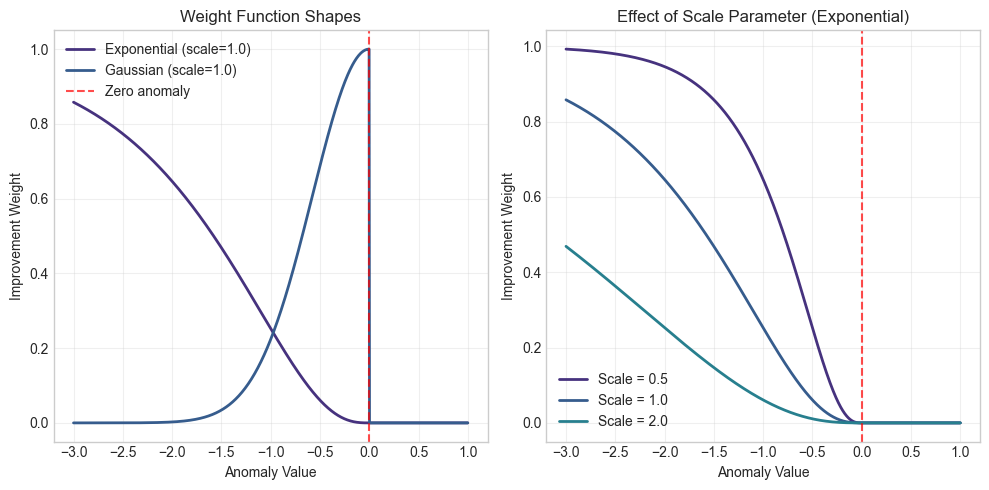

In [25]:
def analyze_improvement_weights(initial_conditions, scenario_params):
    """
    Analyze the behavior of the anomaly improvement weight function.
    """
    print("=== ANOMALY IMPROVEMENT WEIGHT ANALYSIS ===")
    
    # Get weight function parameters
    weight_shape = scenario_params.get('anomaly_weight_shape', 'exponential')
    weight_scale = scenario_params.get('anomaly_weight_scale', 1.0)
    
    print(f"Weight shape: {weight_shape}")
    print(f"Weight scale: {weight_scale}")
    
    # Test weight function behavior across anomaly ranges
    anomaly_range = np.linspace(-3, 1, 1000)  # Typical anomaly range
    
    # Calculate weights for different shapes and scales
    weights_exp_1 = anomaly_improvement_weight(anomaly_range, shape='exponential', scale=1.0)
    weights_exp_05 = anomaly_improvement_weight(anomaly_range, shape='exponential', scale=0.5)
    weights_exp_2 = anomaly_improvement_weight(anomaly_range, shape='exponential', scale=2.0)
    
    try:
        weights_gauss_1 = anomaly_improvement_weight(anomaly_range, shape='gaussian', scale=1.0)
    except:
        weights_gauss_1 = np.zeros_like(anomaly_range)  # If gaussian not available
    
    # Plot weight functions
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot 1: Different shapes
    axes[0].plot(anomaly_range, weights_exp_1, label='Exponential (scale=1.0)', linewidth=2)
    if not np.allclose(weights_gauss_1, 0):
        axes[0].plot(anomaly_range, weights_gauss_1, label='Gaussian (scale=1.0)', linewidth=2)
    axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero anomaly')
    axes[0].set_xlabel('Anomaly Value')
    axes[0].set_ylabel('Improvement Weight')
    axes[0].set_title('Weight Function Shapes')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Different scales (exponential)
    axes[1].plot(anomaly_range, weights_exp_05, label='Scale = 0.5', linewidth=2)
    axes[1].plot(anomaly_range, weights_exp_1, label='Scale = 1.0', linewidth=2)
    axes[1].plot(anomaly_range, weights_exp_2, label='Scale = 2.0', linewidth=2)
    axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Anomaly Value')
    axes[1].set_ylabel('Improvement Weight')
    axes[1].set_title('Effect of Scale Parameter (Exponential)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run weight function analysis if we have the diagnostic data
if 'initial_conditions_diag' in locals():
    analyze_improvement_weights(initial_conditions_diag, test_scenario_params)
else:
    print("Diagnostic data not available - skipping weight analysis")

### Spatial Correlation Analysis

This section analyzes spatial correlations between different anomaly objectives to understand potential conflicts or synergies in restoration decisions.

=== SPATIAL CORRELATION ANALYSIS ===
Analyzing correlations between: ['abiotic_anomaly', 'biotic_anomaly', 'landscape_anomaly']
abiotic_anomaly: 437109 pixels, range [-3.115, 3.132]
biotic_anomaly: 437109 pixels, range [-2.507, 7.555]
landscape_anomaly: 437109 pixels, range [0.000, 1.000]


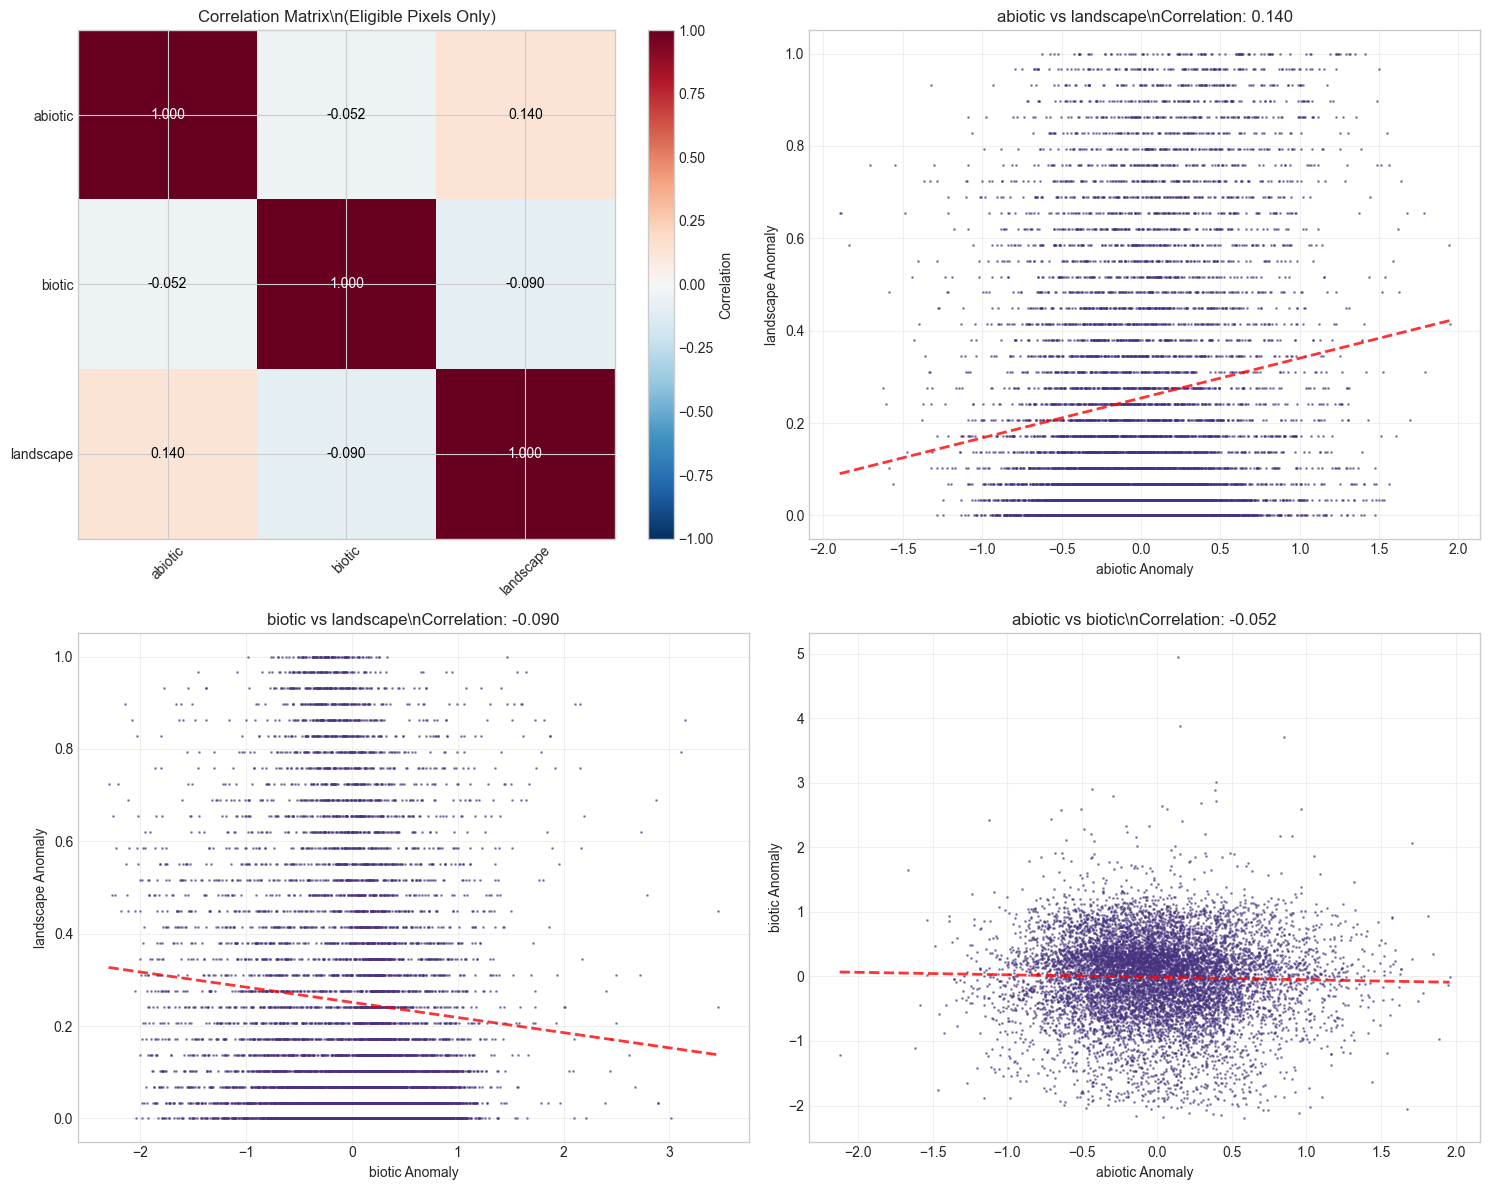

\nCorrelation Summary:
--------------------------------------------------
abiotic vs landscape:  0.140 (Weak Positive)
biotic vs landscape: -0.090 (Weak Negative)
abiotic vs biotic: -0.052 (Weak Negative)
\nImplications for Multi-objective Optimization:
--------------------------------------------------
✓ No extremely strong correlations (|r| > 0.7)
  - Objectives appear reasonably independent
  - Good potential for diverse trade-off solutions


In [ ]:
def analyze_spatial_correlations(initial_conditions):
    """
    Analyze spatial correlations between anomaly objectives.
    """
    print("=== SPATIAL CORRELATION ANALYSIS ===")
    
    # Get available anomaly objectives
    anomaly_objectives = [obj for obj in ['abiotic_anomaly', 'biotic_anomaly', 'landscape_anomaly', 'cost'] 
                         if obj in initial_conditions]
    
    if len(anomaly_objectives) < 2:
        print("Need at least 2 anomaly objectives for correlation analysis")
        return
    
    print(f"Analyzing correlations between: {anomaly_objectives}")
    
    # Get eligible mask for analysis
    eligible_mask = initial_conditions.get('restoration_eligible_mask', 
                                         initial_conditions.get('eligible_mask'))
    
    if eligible_mask is None:
        print("No eligible mask available - using all pixels")
        eligible_mask = np.ones(initial_conditions['shape'], dtype=bool)
    
    # Extract data for eligible pixels
    objective_data = {}
    for obj_name in anomaly_objectives:
        data = initial_conditions[obj_name][eligible_mask]
        objective_data[obj_name] = data
        print(f"{obj_name}: {len(data)} pixels, range [{np.min(data):.3f}, {np.max(data):.3f}]")
    
    # Calculate correlation matrix
    correlation_matrix = np.zeros((len(anomaly_objectives), len(anomaly_objectives)))
    
    for i, obj1 in enumerate(anomaly_objectives):
        for j, obj2 in enumerate(anomaly_objectives):
            if i == j:
                correlation_matrix[i, j] = 1.0
            else:
                corr = np.corrcoef(objective_data[obj1], objective_data[obj2])[0, 1]
                correlation_matrix[i, j] = corr
    
    # Visualize correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Correlation matrix heatmap
    im = axes[0, 0].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0, 0].set_xticks(range(len(anomaly_objectives)))
    axes[0, 0].set_yticks(range(len(anomaly_objectives)))
    axes[0, 0].set_xticklabels([obj.replace('_anomaly', '') for obj in anomaly_objectives], rotation=45)
    axes[0, 0].set_yticklabels([obj.replace('_anomaly', '') for obj in anomaly_objectives])
    axes[0, 0].set_title('Correlation Matrix\n(Eligible Pixels Only)')
    
    # Add correlation values to heatmap
    for i in range(len(anomaly_objectives)):
        for j in range(len(anomaly_objectives)):
            text = axes[0, 0].text(j, i, f'{correlation_matrix[i, j]:.3f}',
                                 ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")
    
    plt.colorbar(im, ax=axes[0, 0], label='Correlation')
    
    # Plot 2-4: Pairwise scatter plots for strongest correlations
    plot_idx = 1
    correlation_pairs = []
    
    for i in range(len(anomaly_objectives)):
        for j in range(i + 1, len(anomaly_objectives)):
            corr = correlation_matrix[i, j]
            correlation_pairs.append((anomaly_objectives[i], anomaly_objectives[j], corr))
    
    # Sort by absolute correlation
    correlation_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for pair_idx, (obj1, obj2, corr) in enumerate(correlation_pairs[:3]):  # Show top 3 pairs
        if plot_idx > 3:
            break
            
        row = plot_idx // 2
        col = plot_idx % 2
        
        # Sample for plotting if too many points
        data1 = objective_data[obj1]
        data2 = objective_data[obj2]
        
        if len(data1) > 10000:
            sample_idx = np.random.choice(len(data1), size=10000, replace=False)
            data1 = data1[sample_idx]
            data2 = data2[sample_idx]
        
        axes[row, col].scatter(data1, data2, alpha=0.5, s=1)
        axes[row, col].set_xlabel(obj1.replace('_anomaly', ' Anomaly'))
        axes[row, col].set_ylabel(obj2.replace('_anomaly', ' Anomaly'))
        axes[row, col].set_title(f'{obj1.replace("_anomaly", "")} vs {obj2.replace("_anomaly", "")}\nCorrelation: {corr:.3f}')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(data1, data2, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(np.min(data1), np.max(data1), 100)
        axes[row, col].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
        
        plot_idx += 1
    
    # Remove empty subplots
    for idx in range(plot_idx, 4):
        row = idx // 2
        col = idx % 2
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation summary
    print(f"\\nCorrelation Summary:")
    print("-" * 50)
    for obj1, obj2, corr in correlation_pairs:
        strength = "Very Strong" if abs(corr) > 0.8 else "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"{obj1.replace('_anomaly', '')} vs {obj2.replace('_anomaly', '')}: {corr:6.3f} ({strength} {direction})")
    
    # Implications for optimization
    print(f"\\nImplications for Multi-objective Optimization:")
    print("-" * 50)
    strong_correlations = [corr for _, _, corr in correlation_pairs if abs(corr) > 0.7]
    
    if strong_correlations:
        print(f"⚠ Strong correlations detected (|r| > 0.7): {len(strong_correlations)} pairs")
        print("  - Objectives may not be independent")
        print("  - Trade-offs between objectives may be limited") 
        print("  - Consider objective reformulation or weighting")
    else:
        print("✓ No extremely strong correlations (|r| > 0.7)")
        print("  - Objectives appear reasonably independent")
        print("  - Good potential for diverse trade-off solutions")
    
    moderate_correlations = [corr for _, _, corr in correlation_pairs if 0.3 < abs(corr) <= 0.7]
    if moderate_correlations:
        print(f"ℹ Moderate correlations (0.3 < |r| ≤ 0.7): {len(moderate_correlations)} pairs")
        print("  - Some synergies/conflicts expected")
        print("  - Multi-objective optimization should find meaningful trade-offs")

# Run spatial correlation analysis
if 'initial_conditions_diag' in locals():
    analyze_spatial_correlations(initial_conditions_diag)
else:
    print("Diagnostic data not available - skipping correlation analysis")